In [ ]:
# ! pip install tqdm

In [1]:
%matplotlib notebook
%matplotlib inline

import os

import numpy as np
import pandas as pd
from pandas import DataFrame as df

from matplotlib import pyplot as plt
# plt.rcParams.update(plt.rcParamsDefault)

import torch

import seaborn as sns
# sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

/tmp/ipykernel_670065/690724472.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
stats = pd.read_pickle(r'iou3d_old_thresh2.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20

In [3]:
BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 4
MAX_PLT_COLS = 5
MAX_PLT_ROWS = 9
CLS_IDX = 2  # Analyzing {1: Car, 2: Ped, 3: Cycl}
fg_gt_thresh = [0.7, 0.5, 0.5]
fg_pl_thresh = [0.65, 0.45, 0.4]
pre_filtering_thresh = fg_pl_thresh[CLS_IDX-1]
cls_names = ['Car', 'Pedestrian', 'Cyclist']

In [4]:
stats_dict = {
    'iou_roi_gt': stats['iou_roi_gt'],
    'iou_roi_pl': stats['iou_roi_pl'],
    'iteration' : stats['iteration'],
    'class_labels': stats['class_labels'],
    'pred_scores': stats['pred_scores']
}
stats_df = pd.DataFrame(stats_dict)

stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
stats_df['iteration'] = stats_df['iteration'].astype('int32')


stats_df = stats_df[pre_filtering_thresh <= stats_df['iou_roi_pl']]

# watch out normalized only if not.
stats['pred_scores'] = torch.tensor(stats['pred_scores']).sigmoid()

# Add type column \in {tp, fp, tn, fn} column based on classwise thresholds
stats_df['type'] = 'n/a'
for cls_ind in range(3):
    cls_mask = stats_df['class_labels'] == cls_ind + 1
    tp_mask = (fg_gt_thresh[cls_ind] <= stats_df['iou_roi_gt']) & (fg_pl_thresh[cls_ind] <= stats_df['iou_roi_pl'])
    fp_mask = (stats_df['iou_roi_gt'] < fg_gt_thresh[cls_ind]) & (fg_pl_thresh[cls_ind] <= stats_df['iou_roi_pl'])
    fn_mask = (fg_gt_thresh[cls_ind] <= stats_df['iou_roi_gt']) & (stats_df['iou_roi_pl'] < fg_pl_thresh[cls_ind])
    tn_mask = (stats_df['iou_roi_gt'] < fg_gt_thresh[cls_ind]) & (stats_df['iou_roi_pl'] < fg_pl_thresh[cls_ind])
    stats_df['type'][tp_mask & cls_mask] = 'tp'
    stats_df['type'][fp_mask & cls_mask] = 'fp'
    stats_df['type'][fn_mask & cls_mask] = 'fn'
    stats_df['type'][tn_mask & cls_mask] = 'tn'


stats_df.reset_index(inplace=True)

In [8]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt(stats_df: pd.DataFrame, cls_ind=CLS_IDX, window_size=WINDOW_SIZE):
    f, axes = plt.subplots(MAX_PLT_ROWS, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    
    palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
    hist_args = dict(hue='type', fill=True, stat='count', legend=True, bins=np.arange(pre_filtering_thresh, 1.02, 0.02), alpha=0.8, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])
    num_windows = stats_df.iteration.max() // window_size
    
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        df_subgroups = []
        for it in range(window_size):
           try:        
              subgroup = stats_df.groupby("iteration").get_group((w * window_size) + it)
              df_subgroups.append(subgroup)
           except KeyError:
               break
        df_subgroups = pd.concat(df_subgroups)
        cls_df = df_subgroups[df_subgroups['class_labels'] == cls_ind]
        sns.histplot(ax=ax, data=cls_df, x="iou_roi_pl", **hist_args)
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)
        
        elif (w + 1) // MAX_PLT_COLS == MAX_PLT_ROWS - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

  0%|          | 0/44 [00:00<?, ?it/s]

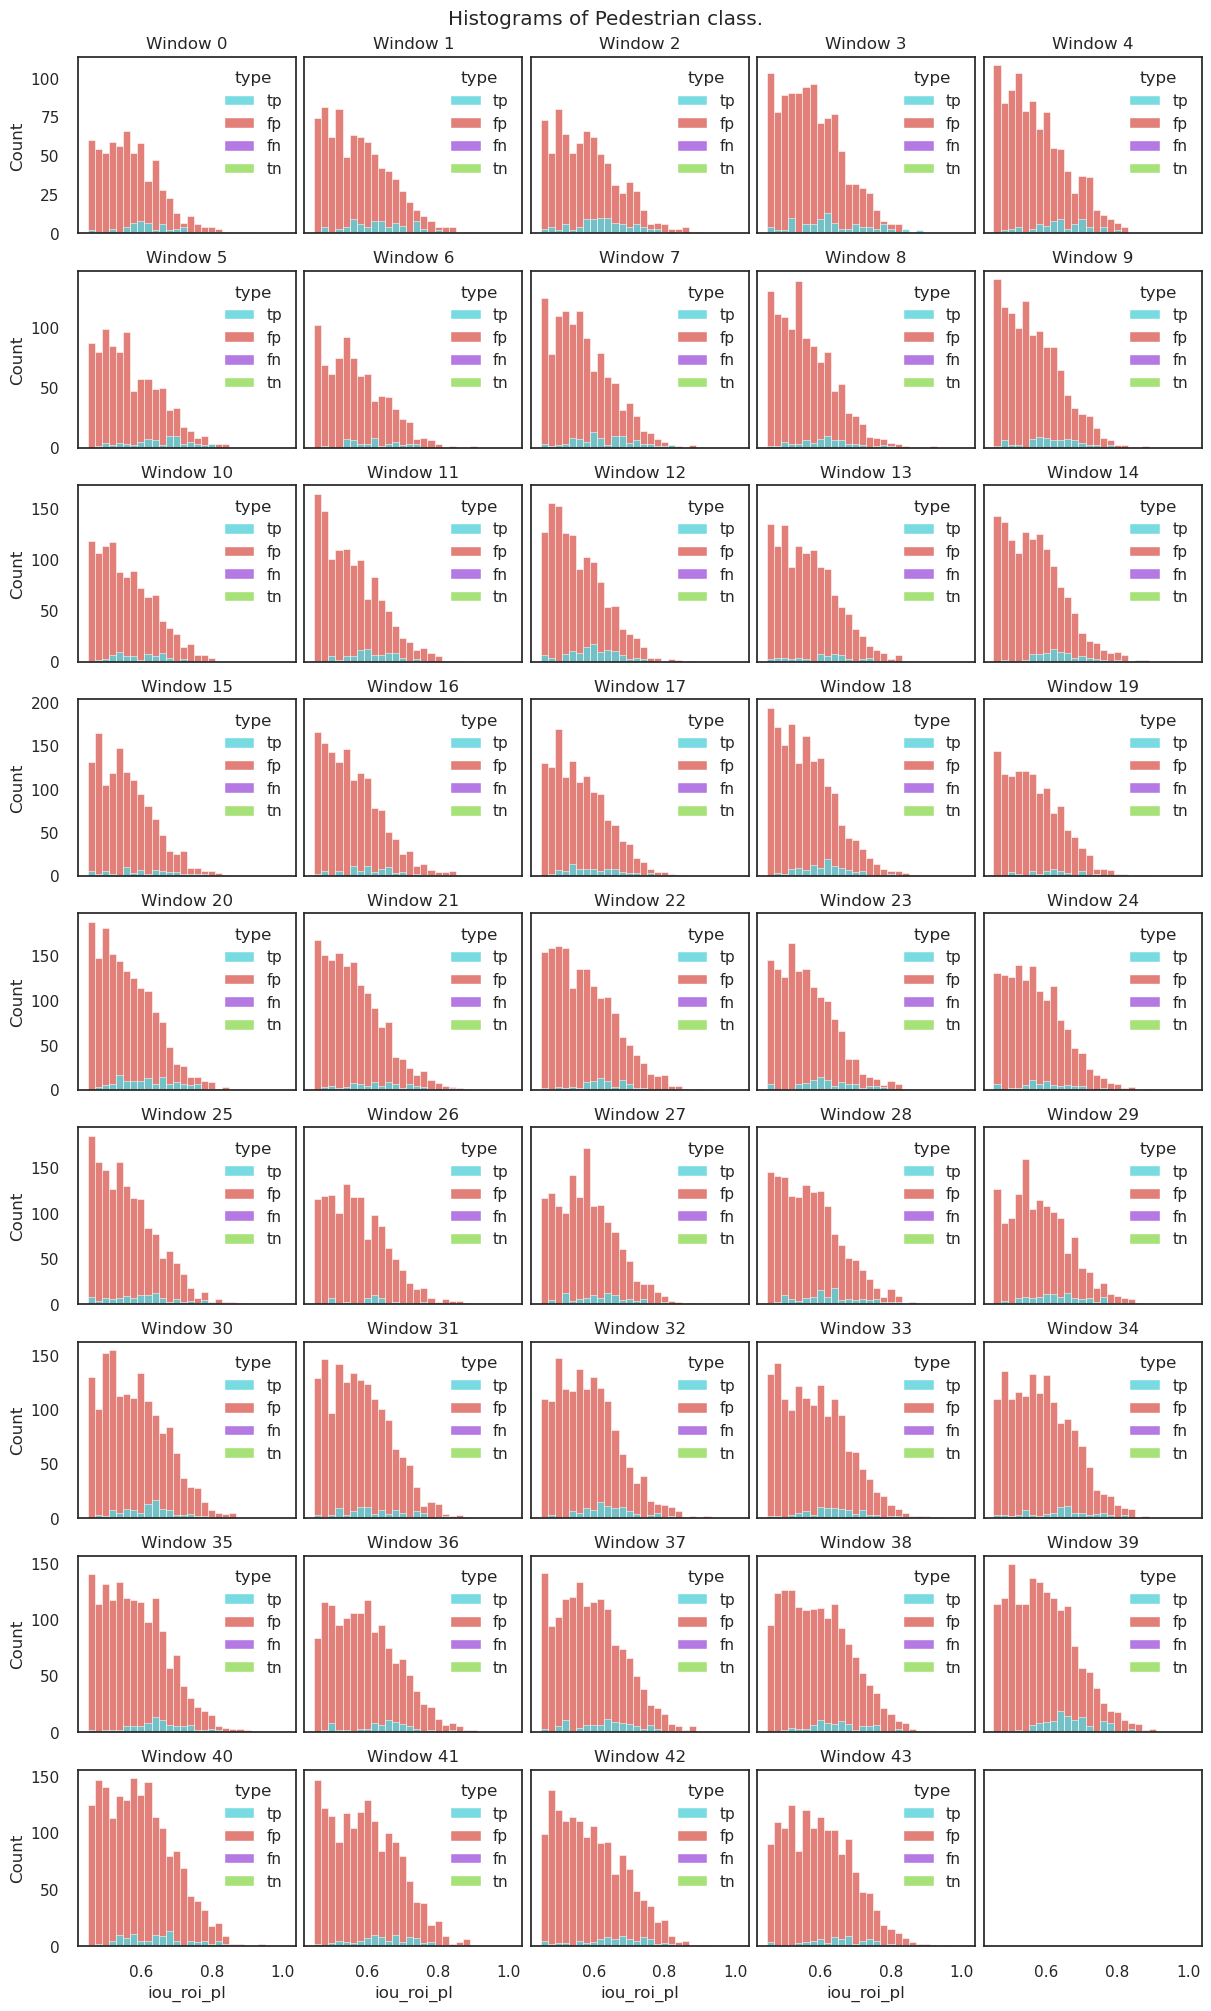

In [9]:
plot_corres_gt(stats_df)